## Soil Organic Carbon model using CNN

This notebook implements the CNN model as per "Modern practical convolutional neural networks for multivariate regression: Applications to NIR calibration": [Reference2](https://www.sciencedirect.com/science/article/abs/pii/S0169743918301382?via%3Dihub) 


As per the investigation, this is a regression problem. Basically here I have used the NIR spectroscopic measurements to predict the soil organic carbon content. I have also referred some analysis functions I found from the spectroscopy blog, nirpyresearch: [Reference1](https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python) 

In [1]:
#importing required packages
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,cross_val_predict

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKerasTF

plt.rcParams["figure.figsize"] = (20,10)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the dataset
df = pd.read_csv("/Users/swaruptripathy/Documents/challenge/stenon_challenge_seniorDS.csv",sep=";")

In [3]:
df.head()

,Unnamed: 0,measurement_ID,lat,lng,label_location,soc_percent_labval,nir_1374,nir_1378,nir_1382,nir_1386,...,uv_811,uv_813,uv_815,uv_817,uv_819,uv_821,uv_823,uv_825,uv_827,uv_829
0,0,bfnknoosf,41.279911,-92.030151,field_A,1.3750779792459,0.266145,0.262247,0.256983,0.250741,...,0.751951,0.754726,0.757226,0.759433,0.761383,0.763123,0.764701,0.766164,0.767560,0.768936
1,1,kaskfansf,41.279854,-92.029450,field_A,1.51338758062445,0.398604,0.393279,0.385631,0.375653,...,0.785473,0.787831,0.790031,0.792063,0.793939,0.795676,0.797293,0.798806,0.800233,0.801592
2,2,boooffnsf,41.279676,-92.027938,field_A,1.53815466576936,0.503565,0.498138,0.489784,0.478757,...,0.675724,0.677911,0.679956,0.681848,0.683606,0.685255,0.686817,0.688319,0.689784,0.691237
3,3,bobbrsnsf,41.279680,-92.027932,field_A,1.52000318313218,0.472190,0.466343,0.457769,0.446611,...,0.726702,0.729272,0.731732,0.734073,0.736302,0.738431,0.740471,0.742434,0.744331,0.746173
4,4,arafssrsf,41.279650,-92.027251,field_A,1.55514929544741,0.458812,0.453379,0.445297,0.434943,...,0.744425,0.747514,0.750423,0.753136,0.755672,0.758057,0.760314,0.762471,0.764552,NaN


In [4]:
df.columns

Index(['Unnamed: 0', 'measurement_ID', 'lat', 'lng', 'label_location',
       'soc_percent_labval', 'nir_1374', 'nir_1378', 'nir_1382', 'nir_1386',
       ...
       'uv_811', 'uv_813', 'uv_815', 'uv_817', 'uv_819', 'uv_821', 'uv_823',
       'uv_825', 'uv_827', 'uv_829'],
      dtype='object', length=479)

In [5]:
## Define random seeds order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(20)
    random.seed(20)
    tf.random.set_seed(20)
    
reproducible_comp()

### Data Description

In [6]:
df.shape

(1588, 479)

In [7]:
nir_count = df.loc[:, df.columns.str.startswith('nir')].size
nir_count

455756

In [8]:
uv_count = df.loc[:, df.columns.str.startswith('uv')].size
uv_count

295368

There are around 1588 rows with 479 columns. Around 455756 NIR readings are captured with 295368 UVVis readings

In [9]:
df.describe()

,Unnamed: 0,lat,lng,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,...,uv_811,uv_813,uv_815,uv_817,uv_819,uv_821,uv_823,uv_825,uv_827,uv_829
count,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1587.000000,1588.000000,1588.000000,1588.000000,1587.000000,...,1588.000000,1588.000000,1588.000000,1588.000000,1588.000000,1587.000000,1588.000000,1588.000000,1587.000000,1587.000000
mean,793.500000,41.196836,-91.854405,0.436951,0.432121,0.424664,0.414051,0.401212,0.386795,0.371340,...,0.782566,0.784923,0.787232,0.789495,0.791715,0.793922,0.796045,0.798164,0.800426,0.802358
std,458.560429,1.792863,3.997453,0.081382,0.080581,0.079279,0.077522,0.075321,0.072895,0.070254,...,0.104090,0.104226,0.104347,0.104454,0.104550,0.104667,0.104724,0.104807,0.104715,0.105010
min,0.000000,0.000000,-92.040639,0.132529,0.130973,0.128310,0.125009,0.121455,0.117773,0.113500,...,0.452464,0.454924,0.457366,0.459788,0.462191,0.464575,0.466941,0.469291,0.471626,0.473947
25%,396.750000,41.272140,-92.032569,0.406463,0.401844,0.394692,0.384594,0.372185,0.357458,0.342433,...,0.727349,0.729952,0.732493,0.734760,0.736854,0.738986,0.741086,0.743074,0.745222,0.747145
50%,793.500000,41.274985,-92.027970,0.448349,0.443988,0.435817,0.424674,0.411054,0.395482,0.378974,...,0.790573,0.792795,0.795383,0.797761,0.799742,0.801920,0.804237,0.806094,0.808091,0.810196
75%,1190.250000,41.276992,-92.021678,0.484269,0.478892,0.470715,0.459150,0.444981,0.429336,0.412167,...,0.848305,0.850357,0.852768,0.854842,0.857269,0.859310,0.861257,0.863299,0.864944,0.866791
max,1587.000000,41.279932,0.000000,0.718165,0.711620,0.700936,0.686183,0.668080,0.647280,0.631115,...,1.829476,1.851825,1.874674,1.898045,1.921963,1.946449,1.971528,1.997221,2.023553,2.050546


#### We can observe that the latitude and longitude is almost within the same range. That means the study data is collected from a single city. Soc percent values average at 1.44 with a median at 1.40 which shows that the data is positively skewed with a standard deviation oof 0.36.
#### We can also observe minimum value of zero within latitude which points to some missing values.

## Data Cleaning and MVI

In [10]:
#Remove all special characters
df["soc_percent_labval"] = df["soc_percent_labval"].str.replace('[#,@,&,<,>]', '')

In [11]:
#Convert datas to float
df["soc_percent_labval"] = df["soc_percent_labval"].astype(float)

In [12]:
#Columns with null values
null_counts = df.isnull().sum().sort_values(ascending=False)
null_counts[null_counts > 0]

uv_829      1
nir_1382    1
nir_2294    1
nir_2138    1
nir_2110    1
uv_571      1
nir_1542    1
nir_1398    1
nir_2318    1
uv_827      1
uv_821      1
dtype: int64

In [13]:
#Column with zero value count
zero_counts = df[df == 0].count(axis=0).sort_values(ascending=False)
zero_counts[zero_counts > 0]

lat           3
lng           3
Unnamed: 0    1
dtype: int64

In [14]:
df.fillna(df.mean(),inplace=True)

In [15]:
df.isnull().sum().sort_values(ascending=False)

Unnamed: 0    0
uv_503        0
uv_527        0
uv_525        0
uv_523        0
             ..
nir_1970      0
nir_1966      0
nir_1962      0
nir_1958      0
uv_829        0
Length: 479, dtype: int64

### Outliers Detection and Removal

Only detecting the outliers with respect to the target variable "SOC" as the spectra data may have lot of outer bounds

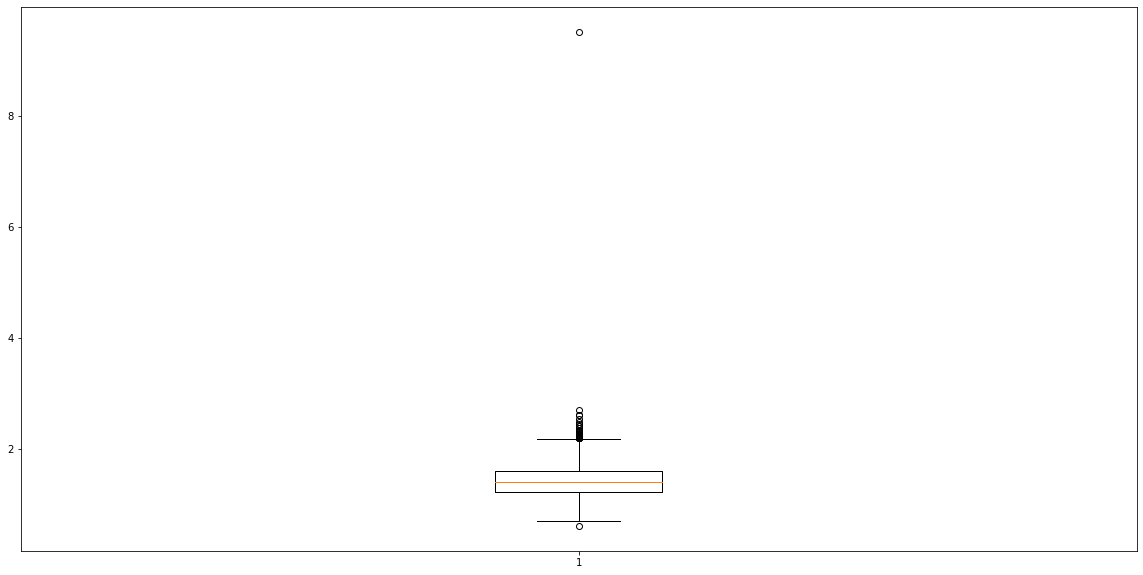

In [16]:
plt.boxplot(df.soc_percent_labval.astype(float))
plt.show()

We can see some outliers on the upper bound of IQR in SOC values

In [17]:
#Function to remove outlier based on IQR
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high), :]
    return df_out

In [18]:
#Calling the outlier function in loop to cross check with any remaining outlier after each iteration
for i in range(5):
    df = remove_outlier(df, "soc_percent_labval")

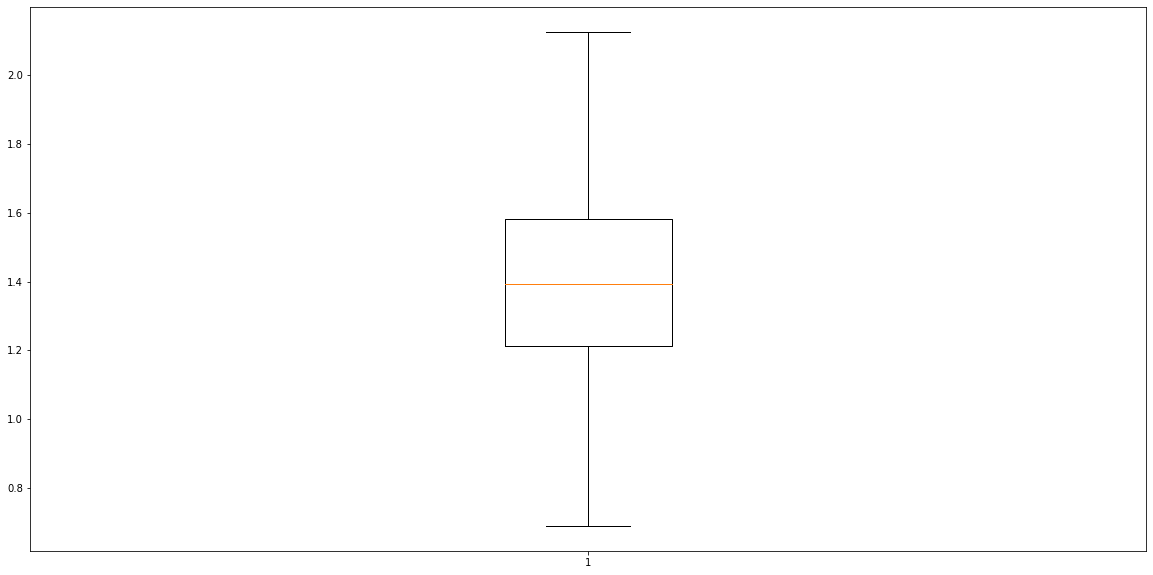

In [19]:
plt.boxplot(df.soc_percent_labval.astype(float))
plt.show()

In [20]:
df.shape

(1545, 479)

As per the above observations outliers has been properly removed from the datas. We are only loosing very few records (1588 - 1545) 43 which is just 2% of the total

### Analysis of NIR wavelength

In [21]:
#Fetching columns with NIR measurements
df_nir = df.loc[:, df.columns.str.startswith('nir')]
df_nir.head()

,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,nir_1406,nir_1410,...,nir_2482,nir_2486,nir_2490,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518
0,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,0.226879,0.218042,0.210194,0.204044,...,0.123917,0.122705,0.121610,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794
1,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,0.335372,0.320722,0.306737,0.294519,...,0.142248,0.140496,0.138907,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455
2,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,0.434083,0.416469,0.399946,0.386453,...,0.199943,0.197408,0.195094,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739
3,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,0.401053,0.383799,0.368113,0.355472,...,0.175535,0.173269,0.171223,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326
4,0.458812,0.453379,0.445297,0.434943,0.422916,0.409532,0.394499,0.378680,0.363423,0.350344,...,0.183226,0.181024,0.179031,0.177286,0.175801,0.174584,0.173643,0.172989,0.172629,0.172573


In [22]:
nir_list = np.linspace(1374, 2518, df_nir.shape[1])

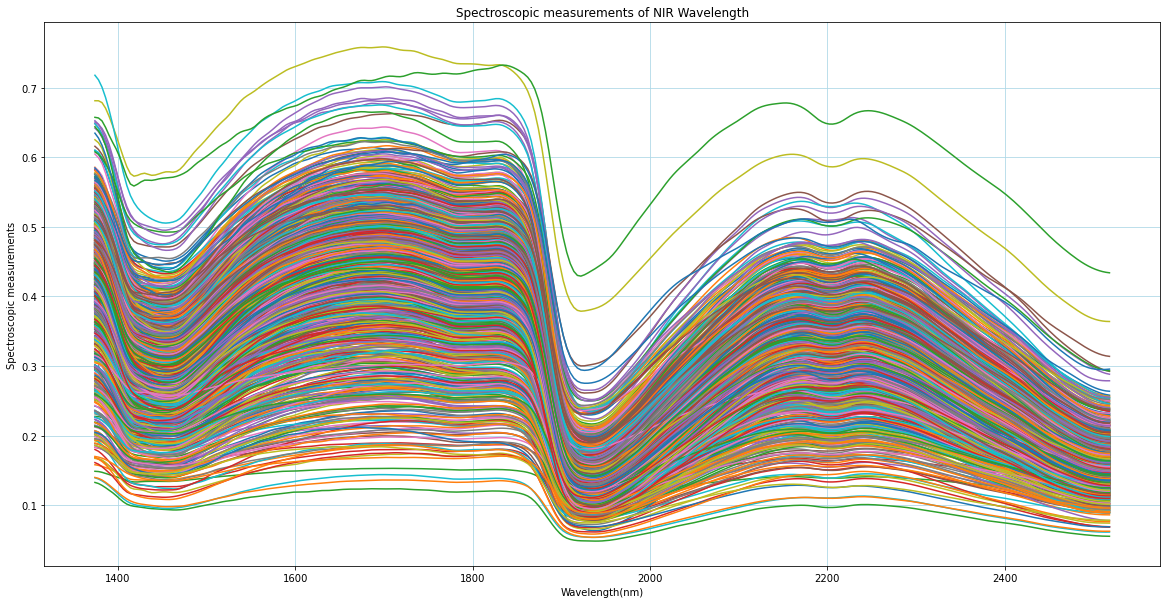

In [23]:
for index, row in df_nir.iterrows():
    plt.plot(nir_list,row.values)

plt.title("Spectroscopic measurements of NIR Wavelength")
plt.xlabel('Wavelength(nm)')
plt.ylabel('Spectroscopic measurements')

plt.grid(True,color='lightblue')
plt.show()

### Analysis of UVVis wavelength

In [24]:
#Fetching columns with UVVis measurements
df_uv = df.loc[:, df.columns.str.startswith('uv')]
df_uv.head()

,uv_459,uv_461,uv_463,uv_465,uv_467,uv_469,uv_471,uv_473,uv_475,uv_477,...,uv_811,uv_813,uv_815,uv_817,uv_819,uv_821,uv_823,uv_825,uv_827,uv_829
0,0.557657,0.550615,0.544131,0.538170,0.532701,0.527688,0.523100,0.518903,0.515063,0.511548,...,0.751951,0.754726,0.757226,0.759433,0.761383,0.763123,0.764701,0.766164,0.767560,0.768936
1,0.636869,0.630050,0.623728,0.617872,0.612450,0.607433,0.602788,0.598485,0.594493,0.590780,...,0.785473,0.787831,0.790031,0.792063,0.793939,0.795676,0.797293,0.798806,0.800233,0.801592
2,0.610028,0.603078,0.596612,0.590604,0.585025,0.579847,0.575044,0.570586,0.566447,0.562599,...,0.675724,0.677911,0.679956,0.681848,0.683606,0.685255,0.686817,0.688319,0.689784,0.691237
3,0.598669,0.592604,0.586859,0.581419,0.576269,0.571391,0.566772,0.562395,0.558245,0.554307,...,0.726702,0.729272,0.731732,0.734073,0.736302,0.738431,0.740471,0.742434,0.744331,0.746173
4,0.601535,0.594304,0.587596,0.581378,0.575615,0.570276,0.565327,0.560735,0.556467,0.552490,...,0.744425,0.747514,0.750423,0.753136,0.755672,0.758057,0.760314,0.762471,0.764552,0.802358


In [25]:
uv_list = np.linspace(459, 829, df_uv.shape[1])

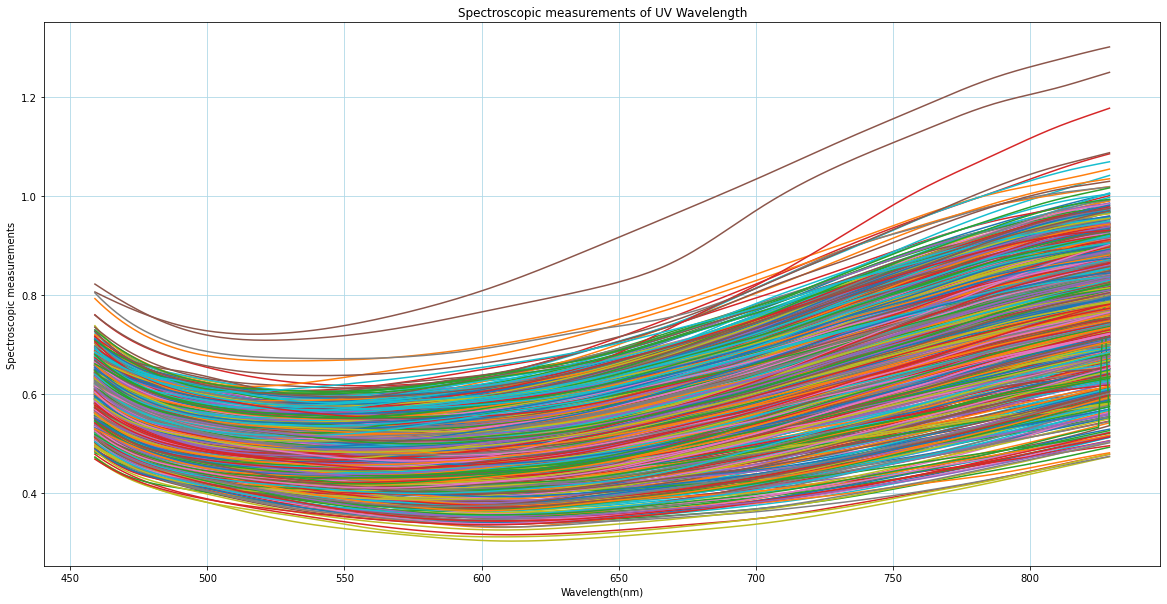

In [26]:
for index, row in df_uv.iterrows():
    plt.plot(uv_list,row.values)

plt.title("Spectroscopic measurements of UV Wavelength")
plt.xlabel('Wavelength(nm)')
plt.ylabel('Spectroscopic measurements')

plt.grid(True,color='lightblue')
plt.show()

#### Taking the necessary variables in X (NIR,UVVi) and Y (SOC) for further analysis

In [27]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [28]:
X = df.iloc[:, 6:]
y = df.soc_percent_labval.astype(float)

In [29]:
X.head()

,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,nir_1406,nir_1410,nir_1414,...,uv_811,uv_813,uv_815,uv_817,uv_819,uv_821,uv_823,uv_825,uv_827,uv_829
0,0.262247,0.256983,0.250741,0.243620,0.235660,0.226879,0.218042,0.210194,0.204044,0.199649,...,0.751951,0.754726,0.757226,0.759433,0.761383,0.763123,0.764701,0.766164,0.767560,0.768936
1,0.393279,0.385631,0.375653,0.363615,0.349929,0.335372,0.320722,0.306737,0.294519,0.285351,...,0.785473,0.787831,0.790031,0.792063,0.793939,0.795676,0.797293,0.798806,0.800233,0.801592
2,0.498138,0.489784,0.478757,0.465691,0.450905,0.434083,0.416469,0.399946,0.386453,0.377325,...,0.675724,0.677911,0.679956,0.681848,0.683606,0.685255,0.686817,0.688319,0.689784,0.691237
3,0.466343,0.457769,0.446611,0.433262,0.418009,0.401053,0.383799,0.368113,0.355472,0.346403,...,0.726702,0.729272,0.731732,0.734073,0.736302,0.738431,0.740471,0.742434,0.744331,0.746173
4,0.453379,0.445297,0.434943,0.422916,0.409532,0.394499,0.378680,0.363423,0.350344,0.340895,...,0.744425,0.747514,0.750423,0.753136,0.755672,0.758057,0.760314,0.762471,0.764552,0.802358


In [30]:
y[0:5]

0    1.375078
1    1.513388
2    1.538155
3    1.520003
4    1.555149
Name: soc_percent_labval, dtype: float64

## NIR spectroscopic measurements

### Splitting data to training and testing samples with NIR as independent variable and SOC as dependent variable

In [31]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_nir, y, test_size = 0.2)

Check the distributions of the train and test Y values. In this case train and test samples have similar distributions, which should be a good thing for the predictions. Some times train and test subsets have very different distributions and that difficults/degrades the models performance.

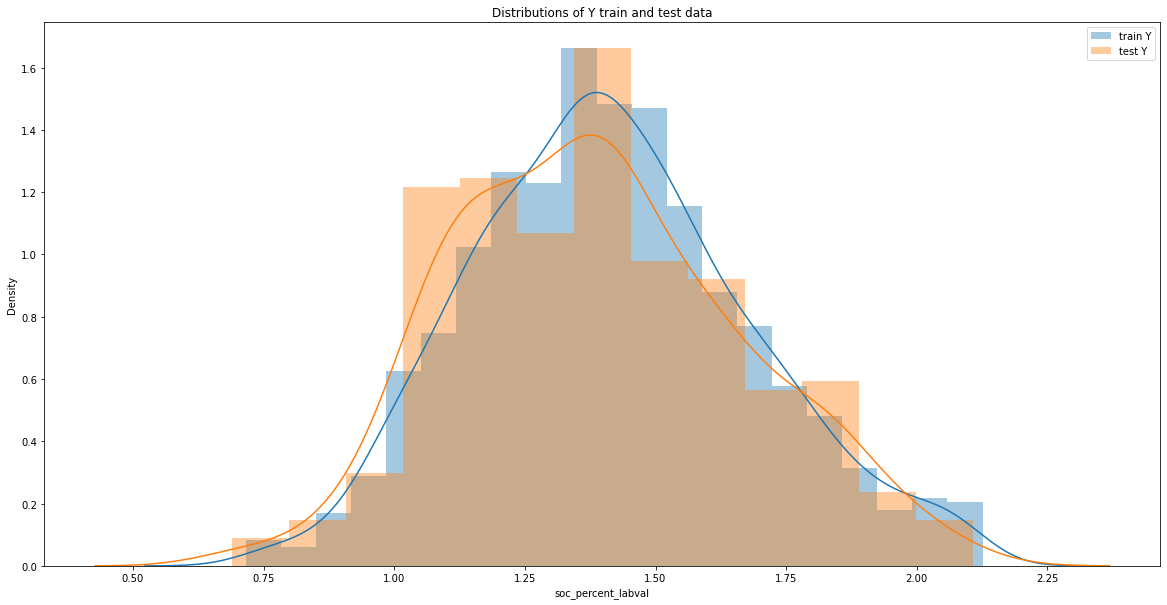

In [32]:
plt.title('Distributions of Y train and test data')
sns.distplot(y_train,label='train Y')
sns.distplot(y_test,label='test Y')
plt.legend()
plt.show()

### Data pre-prossessing 

Preprocessing the data before running neuralnet

#### Standardize the data

In [33]:
#Standardize the data 
def standardize(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return [X_train_scaled, X_test_scaled]

In [34]:
## Standardize 
X_train_scaled, X_test_scaled = standardize(X_train, X_test)

### Implement CNN

The CNN model as per the reference2 paper, propose is composed by an input layer with the same size of the input data (as usual), followed by a Conv1d layer and 3 Fully Connected layer.

Instead of crafting a custom loss function I am implementing L2 regularization. According to Keras documentation "Regularizers allow you to apply penalties on layer parameters (e.g. weights) during optimization. These penalties are summed into the loss function that the network optimizes". Therefore we can choose the loss function as 'mse' and apply an L2 regularization to the weights (by using  tf.keras.regularizers.l2(beta)). The regularization hyperparameter is mentioned in the paper is related to keras.

I am going to use Adam optimizer here as is generally regarded as being fairly robust.

In [35]:
## Layers dimensions
INPUT_DIMS = np.shape(X_train)[1]
CONV1D_DIMS = INPUT_DIMS
K_NUMBER = 1
K_WIDTH = 5
K_STRIDE = 1
FC1_DIMS = 36
FC2_DIMS = 18
FC3_DIMS = 12
OUT_DIMS = 1

## L2 regularizer parameter
beta= 0.003/2.

## For the sake of simplicity we do the weights initialization for multiple layers here
## Due to this, we might have to re-run this cell before each experiment to ensure proper weight initialization each time
K_INIT = tf.keras.initializers.he_normal(seed=42)

## Weights L2 regularization 
K_REG = tf.keras.regularizers.l2(beta)

In [36]:
#Initialize CNN model
model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                keras.layers.Conv1D(filters=K_NUMBER, \
                                                    kernel_size=K_WIDTH, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='elu',\
                                                    input_shape=(CONV1D_DIMS,1)), \
                                keras.layers.Flatten(),
                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(FC2_DIMS, \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu'),
                                keras.layers.Dense(FC3_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(1, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear'),
                              ])

print(model_cnn.summary())


2022-03-16 06:47:37.334312: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 287, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 287, 1)            6         
                                                                 
 flatten (Flatten)           (None, 287)               0         
                                                                 
 dense (Dense)               (None, 36)                10368     
                                                                 
 dense_1 (Dense)             (None, 18)                666       
                                                                 
 dense_2 (Dense)             (None, 12)                228       
                                                                 
 dense_3 (Dense)             (None, 1)                 1

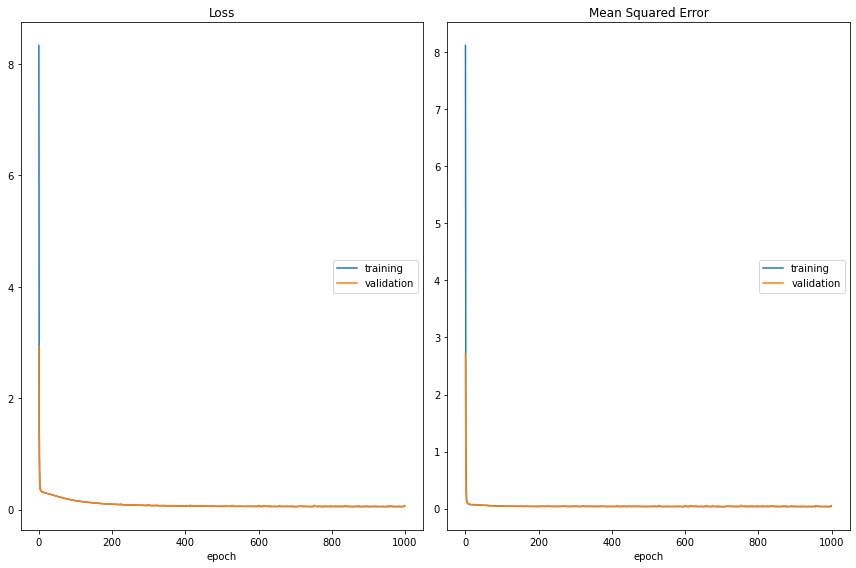

Loss
	training         	 (min:    0.051, max:    8.331, cur:    0.059)
	validation       	 (min:    0.053, max:    2.932, cur:    0.070)
Mean Squared Error
	training         	 (min:    0.033, max:    8.119, cur:    0.041)
	validation       	 (min:    0.035, max:    2.718, cur:    0.052)

Epoch 1000: val_loss did not improve from 0.05285
5/5 [==============================] - 0s 114ms/step - loss: 0.0592 - mse: 0.0415 - val_loss: 0.0695 - val_mse: 0.0519


In [37]:
## plot losses in real time during training process
plot_losses = PlotLossesKerasTF()

##### TRAIN MODEL WITH ADAM OPTIMIZER #########
BATCH=256    
LR=0.01*BATCH/256.

print('Adam learning rate = {}'.format(LR))
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mse'])  

checkpointer= keras.callbacks.ModelCheckpoint(filepath="Swarup_cnn.h5", verbose=1, save_best_only=True)

## Train the model
h1=model_cnn.fit(X_train_scaled, y_train, batch_size=BATCH, epochs=1000, \
          validation_data=(X_test_scaled, y_test),  \
          callbacks=[plot_losses, checkpointer],verbose=1)

tf.keras.backend.clear_session()

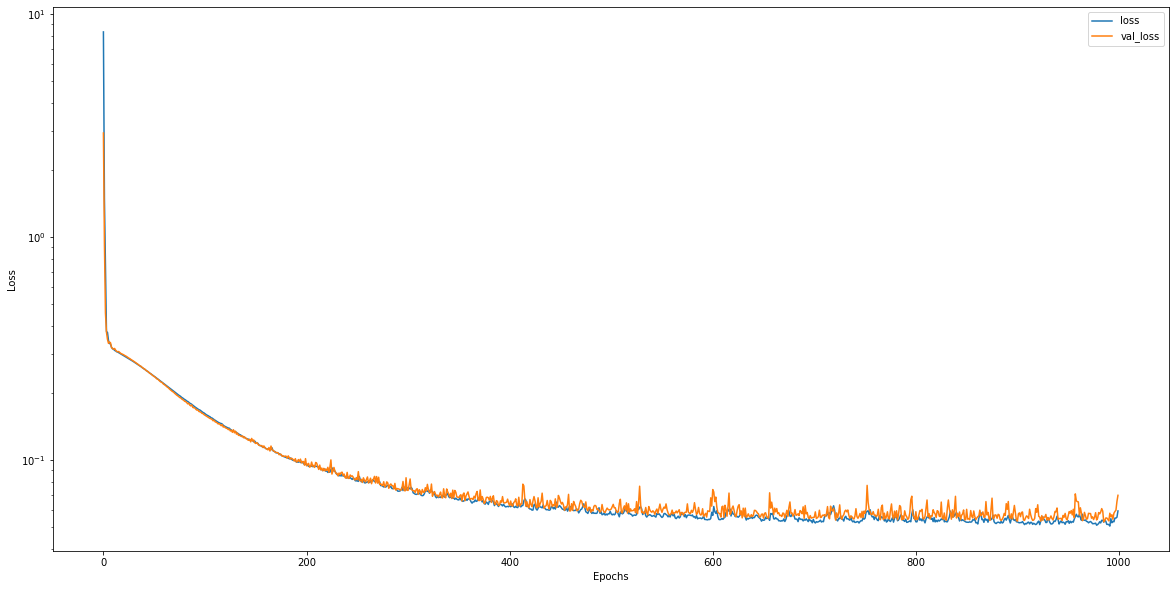

In [38]:
## models history.
plt.plot(h1.history['loss'], label='loss')
plt.plot(h1.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [39]:
## Load best weights and compute error metrics
model_cnn.load_weights('Swarup_cnn.h5')
y_pred_train = model_cnn.predict(X_train_scaled)
y_pred_test  = model_cnn.predict(X_test_scaled)
## Compute RMSE
rmse_train = np.sqrt(mean_squared_error(y_train,y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test,y_pred_test))
## Print metrics
print('Train|   RMSE: {:2.3f}'.format(rmse_train))
print('Test |   RMSE: {:2.3f}'.format(rmse_test))

Train|   RMSE: 0.184
Test |   RMSE: 0.187


The error metrics obtained are almost same as obtained with the PLSR model. 